## MAIN OBJECT CODE [RUN THIS TO INITIALIZE RULES FOR SIMULATION]

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt
##
class Patient:
    def __init__(self, template):
        self.mortality_score = np.clip(template['mortality_score'] + np.random.normal(0, template.get('mortality_std', 0)), 0.05, 0.95) # if it reach 1, patient will die in the next day
        self.category = np.random.choice(template['category'])
        self.waiting_day = 0 # tracking of waiting day
        self.admission_priority = 0 # tracking the admission priority under different strategy
        self.discharge_score = 0 #if it reach 1, patient will be discharged in the next day
        self.hospitalization_day = 0 # tracking of waiting day

class Hospital:
    def __init__(self, bed_dict, bed_count=30, team_count=3):
        self.bed_dict = bed_dict # key is 0-29 (bed number), value is a tuple (medical team, patient)
        self.bed_count = bed_count # max length of bed_list
        self.team_count = team_count
        self.team_patient = np.zeros(team_count)
        self.team_category = np.zeros((team_count, 5)) # array storing number of day since the last encounter for a specific category (column) of patient for each team (row)
        self.available_bed = list(range(bed_count))

# Each day of waiting
def generate_patients(templates, weights, num_patients):
    patients = []
    for _ in range(num_patients):
        random_template = random.choices(templates, weights, k=1)[0]
        patient = Patient(random_template)
        patients.append(patient)
    return patients

def waiting_patients_day(admission_waiting_list, waiting_to_dead_list, mortality_inflation, templates, weights, num_patients):
    '''
    mortality_inflation: rate of
    templates: list of patient template for new patient generation
    weights: possibility of each patient template being selected
    num_patients: number of new patient added per day
    '''
    # modify the old patients
    admission_waiting_list_copy = admission_waiting_list.copy()
    for patient in admission_waiting_list_copy:
        if patient.mortality_score >= 1:
            waiting_to_dead_list.append(patient)
            admission_waiting_list.remove(patient)
            continue
        patient.waiting_day += 1
        patient.mortality_score = np.clip(np.random.normal(patient.mortality_score * mortality_inflation, 0.05), 0, 1)
    # add new patients
    new_patients = generate_patients(templates, weights, num_patients)
    admission_waiting_list.extend(new_patients)
    return admission_waiting_list, waiting_to_dead_list

# Calling admission
def calling_admission(hospital, admission_waiting_list, emergent_mortality_threshold=0.9, preference_weight=[1,1,1]):
    '''
    preference_weight: relative weight of mortality, patient waiting time, educational value (it will be normalize spontaneously)
    '''
    ##### queue the admission waiting list
    # sort the emergent patient with high mortality to the front
    if len(admission_waiting_list) == 0:
        return hospital, admission_waiting_list

    admission_waiting_list.sort(key=lambda patient: patient.mortality_score, reverse=True)
    first_nonemergent_patient = next((i for i, patient in enumerate(admission_waiting_list) if patient.mortality_score <= emergent_mortality_threshold), len(admission_waiting_list))

    # Normalize preference_weight
    preference_weight = np.array(preference_weight)/sum(preference_weight)
    max_waiting_day = max(patient.waiting_day for patient in admission_waiting_list[first_nonemergent_patient:])

    # Calculate the education preference
    team_category_array = hospital.team_category.copy()
    available_team = []
    # If a medical team is full, we don't consider their preference
    for team in range(hospital.team_count):
        if hospital.team_patient[team]>=10:
            team_category_array[team] = np.zeros(5)
        else:
            available_team.append(team) # the team that can handel newly admitted patients

    if np.any(team_category_array != 0):
        team_category_array = np.sum(team_category_array, axis=0)/np.sum(team_category_array) #column sum and noramlize for each patient category
    else:
        team_category_array = np.zeros(5)

    # Sort nonemergent patient based on preference
    for patient in admission_waiting_list[first_nonemergent_patient:]:
        preference_data = np.array([patient.mortality_score, patient.waiting_day/(max_waiting_day+1), team_category_array[patient.category]])
        patient.admission_priority = np.dot(preference_weight, preference_data)

    admission_waiting_list[first_nonemergent_patient:].sort(key=lambda patient: patient.admission_priority, reverse=True)

    ##### calling patient for empty bed
    hospital_available_bed_copy = hospital.available_bed.copy()
    for bed_no in hospital_available_bed_copy:
        hospital.available_bed.remove(bed_no)
        patient = admission_waiting_list.pop(0)
        selected_team = available_team[np.argmax(hospital.team_category[available_team,patient.category])]
        hospital.bed_dict[bed_no] = (selected_team, patient)
        hospital.team_patient[selected_team] +=1 #The team had one more patient
        if hospital.team_patient[selected_team] >=10:
            available_team.remove(selected_team) # The team is no more available
        if len(admission_waiting_list) == 0:
            break
    return hospital, admission_waiting_list

# Each day admitted
def sigmoid(x):
    return - 0.5 / (1 + np.exp((-x+0.5)*10)) + 0.25

def hospital_day(hospital, mortality_reduction):
    # modify team_category in hospital
    hospital.team_category = hospital.team_category + 1

    # modify mortality_score, discharge_score, hospitalization_day in paitents
    hospital_bed_dict_copy = hospital.bed_dict.copy()
    for bed_no, (team_no, patient) in hospital_bed_dict_copy.items():

        unfamiliarity = hospital.team_category[team_no , patient.category] + 1 # how long the team had no experience taking care of such patient

        patient.mortality_score = np.clip(np.random.normal(patient.mortality_score * mortality_reduction, 0.1 * unfamiliarity), 0, 1)
        patient.discharge_score = np.clip((patient.discharge_score + sigmoid(patient.mortality_score) - unfamiliarity / 10), 0, 1)
        patient.hospitalization_day += 1

        hospital.team_category[team_no, patient.category] = 0 # become familier after caring for patient
    return hospital

# Hospital discharge
def hospital_discharge(hospital, discharge_alive_list, discharge_dead_list):
    hospital_bed_dict_copy = hospital.bed_dict.copy()
    for bed_no, (team_no, patient) in hospital_bed_dict_copy.items():
        if patient.mortality_score >= 1:
            dead_patient = hospital.bed_dict.pop(bed_no)
            discharge_dead_list.append(dead_patient)
            hospital.team_patient[team_no] -=1
            hospital.available_bed.append(bed_no)
        elif patient.discharge_score >= 1:
            discharged_patient = hospital.bed_dict.pop(bed_no)
            discharge_alive_list.append(discharged_patient)
            hospital.team_patient[team_no] -=1
            hospital.available_bed.append(bed_no)
    return hospital, discharge_alive_list, discharge_dead_list

## [OPTIONAL] TESTING CODE [RUN TO SEE IF THE DEFINITIONS WORK WITH RAW OUTPUTS]

In [2]:
# Template for patient generation
template_disease = {
    'mortality_score': 0.25,
    'mortality_std': 0.125,
    'category': [0]
}

template_survey = {
    'mortality_score': 0.1,
    'mortality_std': 0.05,
    'category': [1, 2, 3, 4]
}

# Parameter in patient generation and waiting admission
templates = [template_disease, template_survey]
weights=[0.8, 0.2] # weight of drawing from each template
num_patients = 5 # number of patient generated per day
mortality_inflation = 1.1 # expected mortality change per day

# Parameter for calling admission
preference_weight = [1,1,1] # relative weight of mortality, patient waiting time, educational value (it will be normalize spontaneously)
emergent_mortality_threshold = 0.9 # If mortality is higher than this, the patient had the highest priority of admission

# Parameter for hospitalized patient
mortality_reduction = 0.8 # expected mortality change per day

# Initialization
discharge_alive_list = []
discharge_dead_list = []
waiting_to_dead_list = []
admission_waiting_list = generate_patients(templates, weights, num_patients) # some patient generated during initialization

hospital = Hospital(bed_dict={}, bed_count=30, team_count=3)

In [3]:
days = 1
for _ in range(days):
    # Discharge
    hospital, discharge_alive_list, discharge_dead_list = hospital_discharge(hospital, discharge_alive_list, discharge_dead_list)

    # Calling admission
    hospital, admission_waiting_list = calling_admission(hospital, admission_waiting_list, emergent_mortality_threshold, preference_weight)

    # Passing of the day in waiting list
    admission_waiting_list, waiting_to_dead_list = waiting_patients_day(admission_waiting_list, waiting_to_dead_list, mortality_inflation, templates, weights, num_patients)

    # Passing of the day in hospital
    hospital = hospital_day(hospital, mortality_reduction)

In [4]:
# Visualize this for the hospital
hospital.bed_dict

{0: (0, <__main__.Patient at 0x143d7e18d90>),
 1: (0, <__main__.Patient at 0x143d7e18e80>),
 2: (0, <__main__.Patient at 0x143d7e187c0>),
 3: (0, <__main__.Patient at 0x143d7e18850>),
 4: (0, <__main__.Patient at 0x143d7e18d00>)}

In [ ]:
# Visualize these for admission waiting patient
admission_waiting_list
waiting_to_dead_list

# Visualize these two seperately for the discharged patient
discharge_alive_list
discharge_dead_list

[(2, <__main__.Patient at 0x231f4524f40>)]

In [7]:
# Print results
print("Admission Waiting List:")
for i, patient in enumerate(admission_waiting_list, start=1):
    print(f"Patient {i}:")
    print(f"  Mortality Score: {patient.mortality_score}")
    print(f"  Waiting Time: {patient.waiting_day}")
    print(f"  Category: {patient.category}")
    print()

print("Waiting to Dead List:")
for i, patient in enumerate(waiting_to_dead_list, start=1):
    print(f"Patient {i}:")
    print(f"  Mortality Score: {patient.mortality_score}")
    print(f"  Waiting Time: {patient.waiting_day}")
    print(f"  Category: {patient.category}")
    print()

Admission Waiting List:
Patient 1:
  Mortality Score: 0.9769551197473655
  Waiting Time: 7
  Category: 0

Patient 2:
  Mortality Score: 1.0
  Waiting Time: 12
  Category: 0

Patient 3:
  Mortality Score: 1.0
  Waiting Time: 35
  Category: 0

Patient 4:
  Mortality Score: 1.0
  Waiting Time: 26
  Category: 3

Patient 5:
  Mortality Score: 1.0
  Waiting Time: 17
  Category: 0

Patient 6:
  Mortality Score: 1.0
  Waiting Time: 31
  Category: 0

Patient 7:
  Mortality Score: 0.9998479781173589
  Waiting Time: 18
  Category: 0

Patient 8:
  Mortality Score: 1.0
  Waiting Time: 19
  Category: 0

Patient 9:
  Mortality Score: 1.0
  Waiting Time: 12
  Category: 0

Patient 10:
  Mortality Score: 1.0
  Waiting Time: 20
  Category: 0

Patient 11:
  Mortality Score: 0.8150860598418543
  Waiting Time: 7
  Category: 0

Patient 12:
  Mortality Score: 0.8665331375873699
  Waiting Time: 8
  Category: 0

Patient 13:
  Mortality Score: 0.8743036512496475
  Waiting Time: 16
  Category: 0

Patient 14:
  Mo

In [6]:
for i, (team, patient) in enumerate(discharge_dead_list, start=1):
    print(f"Patient {i}:")
    print(f"  Care Team: {team} ")
    print(f"  Category: {patient.category}")
    print(f"  Waiting Time: {patient.waiting_day}")
    print(f"  Admission Duration: {patient.hospitalization_day}")
    print(f"  Admission Priority Upon admission: {patient.admission_priority}")
    print(f"  Discharge Score: {patient.discharge_score}")
    print(f"  Mortality Score: {patient.mortality_score}")
    print()

In [8]:
for i, (team, patient) in enumerate(discharge_alive_list, start=1):
    print(f"Patient {i}:")
    print(f"  Care Team: {team} ")
    print(f"  Category: {patient.category}")
    print(f"  Waiting Time: {patient.waiting_day}")
    print(f"  Admission Duration: {patient.hospitalization_day}")
    print(f"  Admission Priority Upon admission: {patient.admission_priority}")
    print(f"  Discharge Score: {patient.discharge_score}")
    print(f"  Mortality Score: {patient.mortality_score}")
    print()

Patient 1:
  Care Team: 0 
  Category: 0
  Waiting Time: 0
  Admission Duration: 7
  Admission Priority Upon admission: 0.04507173595116904
  Discharge Score: 1.0
  Mortality Score: 0.09825376828390651

Patient 2:
  Care Team: 0 
  Category: 0
  Waiting Time: 0
  Admission Duration: 8
  Admission Priority Upon admission: 0.09963085124872709
  Discharge Score: 1.0
  Mortality Score: 0.11904735453392132

Patient 3:
  Care Team: 0 
  Category: 0
  Waiting Time: 0
  Admission Duration: 9
  Admission Priority Upon admission: 0.11125462547671244
  Discharge Score: 1.0
  Mortality Score: 0.2795256034240976

Patient 4:
  Care Team: 1 
  Category: 0
  Waiting Time: 0
  Admission Duration: 8
  Admission Priority Upon admission: 0.1503104548517123
  Discharge Score: 1.0
  Mortality Score: 0.21355963205775863

Patient 5:
  Care Team: 1 
  Category: 0
  Waiting Time: 0
  Admission Duration: 8
  Admission Priority Upon admission: 0.13673939153645837
  Discharge Score: 1.0
  Mortality Score: 0.020558

# Simulation Testing

## First Sim Test (tables added for debugging)

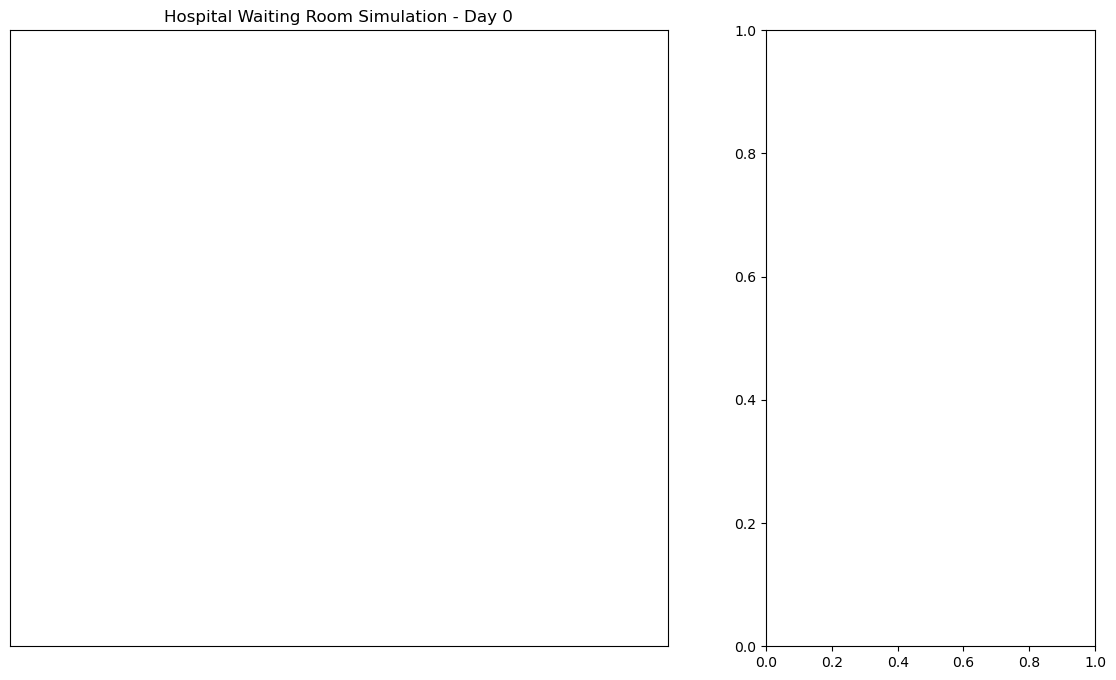

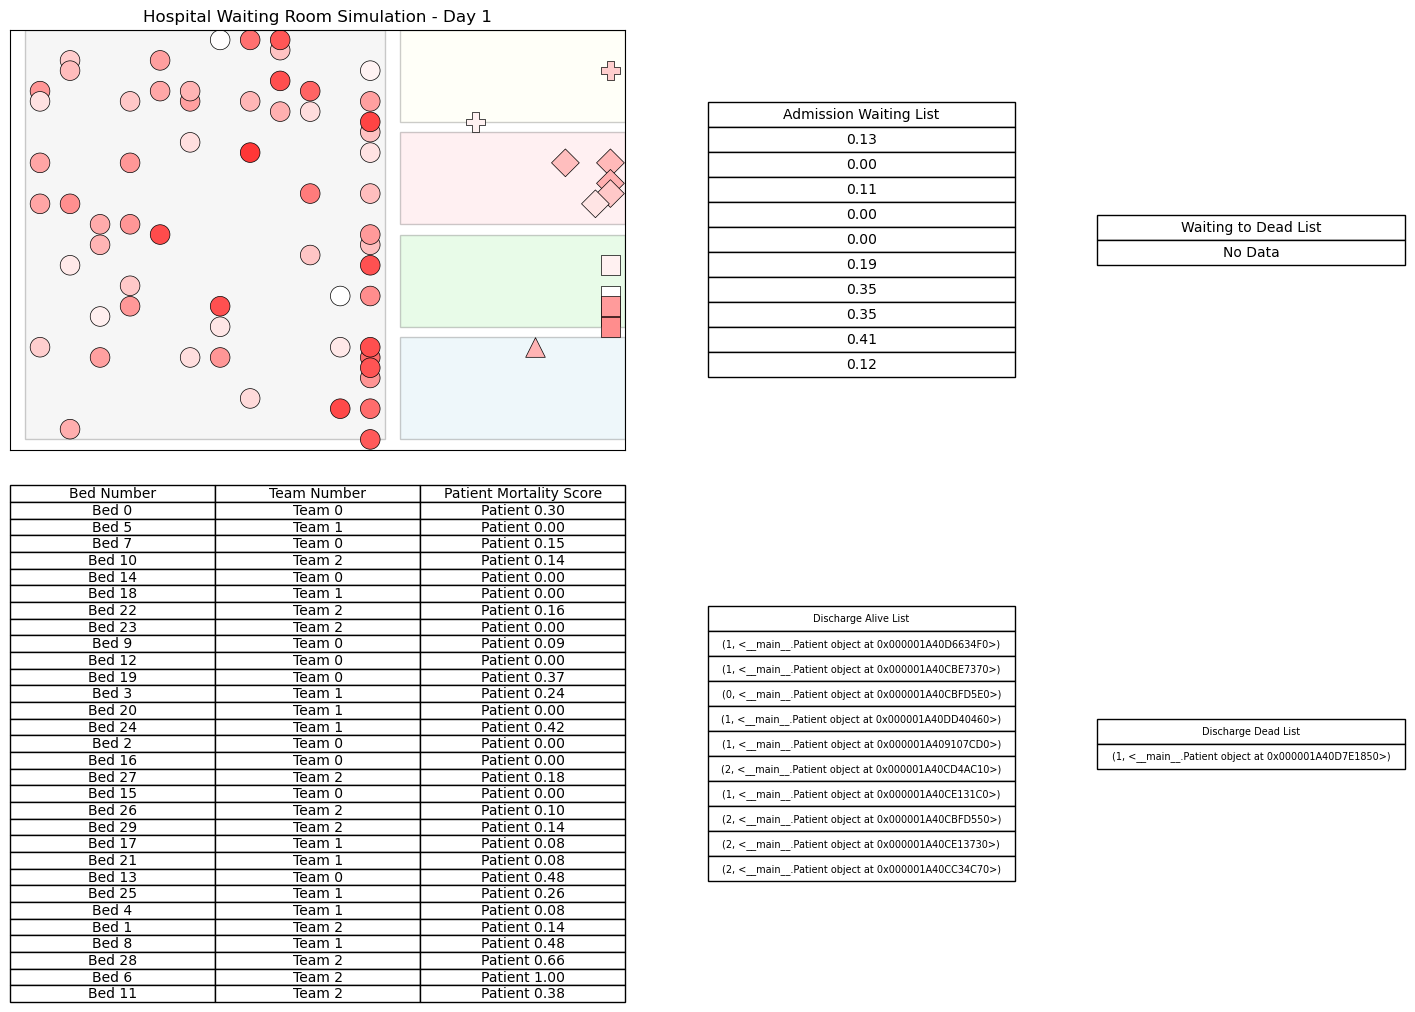

In [27]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import random
from matplotlib.table import Table
from IPython.display import HTML

#### Parameters for simulation ####
GRID_SIZE = 40  # Grid dimensions for the waiting room
days = 30

# Simulaton Patient Initialization Blocks [set the shapes, and disease category distribution]
CATEGORY_SHAPES = {
    1: '^',  # Triangle
    2: 's',  # Square
    3: 'D',  # Diamond
    4: 'P'   # Cross
}
template_disease = {
    'mortality_score': 0.25,
    'mortality_std': 0.125,
    'category': [0]
}
template_survey = {
    'mortality_score': 0.1,
    'mortality_std': 0.05,
    'category': [1, 2, 3, 4]
}

templates = [template_disease, template_survey]
weights = [0.8, 0.2]
num_patients = 5
mortality_inflation = 1.1
preference_weight = [1, 1, 1]
emergent_mortality_threshold = 0.9
mortality_reduction = 0.8


def initialize_positions(admission_waiting_list, GRID_SIZE):
    """
    Initializes positions for patients based on their category regions.
    Ensures no two patients overlap and positions stay within their designated regions.
    """
    positions = {}
    for patient in admission_waiting_list:
        category = patient.category  # Assume patient objects have a `category` attribute.
        x_min, x_max, y_min, y_max = get_region_bounds(category, GRID_SIZE)

        # Generate random coordinates within the category's region
        x, y = random.randint(x_min, x_max), random.randint(y_min, y_max)
        while (x, y) in positions.values():  # Ensure no two patients share a position
            x, y = random.randint(x_min, x_max), random.randint(y_min, y_max)
        positions[patient] = (x, y)
    return positions

# Define grid regions for each category
def get_region_bounds(category, GRID_SIZE):
    """
    Get the bounds of the grid region for the given category.
    Ensures no overlap between categories by introducing buffer zones.
    """
    if not isinstance(GRID_SIZE, int):
        raise TypeError(f"Expected GRID_SIZE to be int, but got {type(GRID_SIZE)}")

    buffer = 1  # Add a buffer zone of 1 unit between regions

    if category == 0:  # Common patients
        return 0, int(0.6 * GRID_SIZE) - buffer, 0, GRID_SIZE - 1  # Large region
    elif category == 1:
        return int(0.6 * GRID_SIZE) + buffer, GRID_SIZE - 1, 0, int(0.25 * GRID_SIZE) - buffer
    elif category == 2:
        return int(0.6 * GRID_SIZE) + buffer, GRID_SIZE - 1, int(0.25 * GRID_SIZE) + buffer, int(0.5 * GRID_SIZE) - buffer
    elif category == 3:
        return int(0.6 * GRID_SIZE) + buffer, GRID_SIZE - 1, int(0.5 * GRID_SIZE) + buffer, int(0.75 * GRID_SIZE) - buffer
    elif category == 4:
        return int(0.6 * GRID_SIZE) + buffer, GRID_SIZE - 1, int(0.75 * GRID_SIZE) + buffer, GRID_SIZE - 1
    else:
        raise ValueError(f"Invalid category: {category}")

def update_positions(positions, GRID_SIZE, direction_memory, admission_waiting_list):
    """
    Updates positions with human-like movement and aligns them based on waiting days.
    """
    # Increment waiting days for all patients
    for patient in admission_waiting_list:
        patient.waiting_day += 1

    for patient in admission_waiting_list:
        x, y = positions[patient]
        category = patient.category

        # Get the region bounds for this patient's category
        x_min, x_max, y_min, y_max = get_region_bounds(category, GRID_SIZE)

        # Calculate the x-position based on waiting days (longer waits to the right)
        x_position = x_min + min(patient.waiting_day, x_max - x_min)

        # Keep y-position random within bounds
        new_y = random.randint(y_min, y_max)

        # Prevent overlap by slightly adjusting the position if necessary
        new_x = max(x_min, min(x_max, x_position))
        while (new_x, new_y) in positions.values():
            new_y = random.randint(y_min, y_max)

        # Update position
        positions[patient] = (new_x, new_y)

        # Update direction memory to reflect minimal movement
        direction_memory[patient] = (1, 0)  # Moving rightward in the x-direction

# Create patients and initialize the hospital
admission_waiting_list = generate_patients(templates, weights, num_patients)
waiting_to_dead_list = []
discharge_alive_list = []
discharge_dead_list = []
hospital = Hospital(bed_dict={}, bed_count=30, team_count=3)
positions = initialize_positions(admission_waiting_list, GRID_SIZE)
direction_memory = {}

# Set up the figure with two subplots: one for the animation, one for the table
fig, axs = plt.subplots(1, 2, figsize=(14, 8), gridspec_kw={'width_ratios': [2, 1]})
ax_simulation, ax_table = axs
ax_simulation.set_xlim(-1, GRID_SIZE)
ax_simulation.set_ylim(-1, GRID_SIZE)
ax_simulation.set_xticks([])  # Hide x-axis numbers
ax_simulation.set_yticks([])  # Hide y-axis numbers
ax_simulation.grid(True, linestyle='--', alpha=0.5)
title = ax_simulation.set_title("Hospital Waiting Room Simulation - Day 0")

# Initialize scatter plot containers for different markers
scatter_dots = ax_simulation.scatter([], [], s=200, edgecolors='black', linewidth=0.5, label="Dots (Category 0)")
scatter_shapes = {cat: ax_simulation.scatter([], [], marker=shape, s=200, edgecolors='black', linewidth=0.5, label=f"Category {cat}") for cat, shape in CATEGORY_SHAPES.items()}

def update_single_table(ax, data, title, is_hospital=False, cap=10):
    """
    Updates a single table with a row cap.

    Parameters:
    - ax: The axis to draw the table.
    - data: The data to display in the table.
    - title: The title of the table.
    - is_hospital: Boolean flag to handle `hospital.bed_dict` formatting.
    - cap: The maximum number of rows to display.
    """
    ax.clear()
    ax.axis('off')  # Hide axes

    # Format the data into rows
    if is_hospital:
        # Special formatting for `hospital.bed_dict`
        rows = [[f"Bed {bed_no}", f"Team {team_no}", f"Patient {patient.mortality_score:.2f}"]
                for bed_no, (team_no, patient) in list(data.items())[-cap:]]  # Show last `cap` rows
        if not rows:
            rows = [["No Data", "No Data", "No Data"]]
        col_labels = ["Bed Number", "Team Number", "Patient Mortality Score"]
        scale_width = 1.0
        scale_height = 1.0  # Shrink the height for the bed table
        font_size = 6       # Smaller font for the bed table
    else:
        # General case for other lists
        def format_item(item):
            if hasattr(item, 'mortality_score'):
                return f"{item.mortality_score:.2f}"
            elif isinstance(item, tuple):
                return str(item)  # Convert tuple to string for display
            return 'No Data'

        rows = [[format_item(data[i])] if i < len(data) else ['No Data']
                for i in range(max(len(data) - cap, 0), len(data))]
        if not rows:
            rows = [["No Data"]]
        col_labels = [title]
        scale_width = 1.0
        scale_height = 1.5  # Default height scaling

    # Add headers and data to the table
    table = ax.table(
        cellText=rows,
        colLabels=col_labels,
        loc='center',
        cellLoc='center',
    )

    # Customize the table for better appearance
    table.auto_set_font_size(True)  # Disable automatic font scaling
    table.scale(scale_width, scale_height)  # Scale table size
    for key, cell in table.get_celld().items():
        cell.PAD = 0.01             # Minimize padding to fit text

# Animation update function
def update(frame):
    global admission_waiting_list, waiting_to_dead_list, discharge_alive_list, discharge_dead_list, hospital, positions

    if frame == 0:
        # Frame 0: Display initial state with patients in the grid
        dots_x, dots_y, dots_colors = [], [], []
        shape_coords = {cat: ([], []) for cat in CATEGORY_SHAPES.keys()}
        shape_colors = {cat: [] for cat in CATEGORY_SHAPES.keys()}

        for patient, (x, y) in positions.items():
            color = (1, 1 - patient.mortality_score, 1 - patient.mortality_score)  # White to red gradient
            if patient.category == 0:
                dots_x.append(x)
                dots_y.append(y)
                dots_colors.append(color)
            elif patient.category in CATEGORY_SHAPES:
                shape_coords[patient.category][0].append(x)
                shape_coords[patient.category][1].append(y)
                shape_colors[patient.category].append(color)

        # Update dots
        scatter_dots.set_offsets(np.c_[dots_x, dots_y])
        scatter_dots.set_facecolor(dots_colors)

        # Update shapes for each category
        for cat in CATEGORY_SHAPES:
            scatter_shapes[cat].set_offsets(np.c_[shape_coords[cat][0], shape_coords[cat][1]])
            scatter_shapes[cat].set_facecolor(shape_colors[cat])

        # Update the title and tables
        title.set_text(f"Hospital Waiting Room Simulation - Day {frame + 1}")
        update_single_table(ax_admission, admission_waiting_list, "Admission Waiting List", cap=10)
        update_single_table(ax_waiting_to_dead, waiting_to_dead_list, "Waiting to Dead List", cap=10)
        update_single_table(ax_discharge_alive, discharge_alive_list, "Discharge Alive List", cap=10)
        update_single_table(ax_discharge_dead, discharge_dead_list, "Discharge Dead List", cap=10)
        update_single_table(ax_hospital, hospital.bed_dict, "Hospital Beds", is_hospital=True, cap=30)
        return

    # Normal simulation updates from Day 1 onwards
    hospital, discharge_alive_list, discharge_dead_list = hospital_discharge(hospital, discharge_alive_list, discharge_dead_list)
    hospital, admission_waiting_list = calling_admission(hospital, admission_waiting_list, emergent_mortality_threshold, preference_weight)
    admission_waiting_list, waiting_to_dead_list = waiting_patients_day(
        admission_waiting_list, waiting_to_dead_list, mortality_inflation, templates, weights, num_patients
    )
    hospital = hospital_day(hospital, mortality_reduction)

    # Remove admitted or discharged patients from the waiting room positions
    for _, (_, patient) in hospital.bed_dict.items():
        if patient in positions:
            del positions[patient]

    for patient in discharge_alive_list + discharge_dead_list:
        if patient in positions:
            del positions[patient]

    # Synchronize positions with the remaining admission_waiting_list
    for patient in admission_waiting_list:
        if patient not in positions:
            x, y = random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1)
            while (x, y) in positions.values():
                x, y = random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1)
            positions[patient] = (x, y)

    # Update positions of all patients
    update_positions(positions, GRID_SIZE, direction_memory, admission_waiting_list)

    # Remove dead patients from the visualization
    for patient in waiting_to_dead_list:
        if patient in positions:
            del positions[patient]

    # Update scatter plot data for each category
    dots_x, dots_y, dots_colors = [], [], []
    shape_coords = {cat: ([], []) for cat in CATEGORY_SHAPES.keys()}
    shape_colors = {cat: [] for cat in CATEGORY_SHAPES.keys()}

    for patient, (x, y) in positions.items():
        color = (1, 1 - patient.mortality_score, 1 - patient.mortality_score)  # White to red gradient
        if patient.category == 0:
            dots_x.append(x)
            dots_y.append(y)
            dots_colors.append(color)
        elif patient.category in CATEGORY_SHAPES:
            shape_coords[patient.category][0].append(x)
            shape_coords[patient.category][1].append(y)
            shape_colors[patient.category].append(color)

    # Update dots
    scatter_dots.set_offsets(np.c_[dots_x, dots_y])
    scatter_dots.set_facecolor(dots_colors)

    # Update shapes for each category
    for cat in CATEGORY_SHAPES:
        scatter_shapes[cat].set_offsets(np.c_[shape_coords[cat][0], shape_coords[cat][1]])
        scatter_shapes[cat].set_facecolor(shape_colors[cat])

    # Update the title to reflect the current day
    title.set_text(f"Hospital Waiting Room Simulation - Day {frame + 1}")

    # Update the individual tables with caps
    update_single_table(ax_admission, admission_waiting_list, "Admission Waiting List", cap=10)
    update_single_table(ax_waiting_to_dead, waiting_to_dead_list, "Waiting to Dead List", cap=10)
    update_single_table(ax_discharge_alive, discharge_alive_list, "Discharge Alive List", cap=10)
    update_single_table(ax_discharge_dead, discharge_dead_list, "Discharge Dead List", cap=10)
    update_single_table(ax_hospital, hospital.bed_dict, "Hospital Beds", is_hospital=True, cap=30)

def draw_region_overlays(ax, GRID_SIZE):
    """
    Draws region overlays for each category on the simulation plot.
    """
    region_colors = ['lightgray', 'lightblue', 'lightgreen', 'lightpink', 'lightyellow']  # Colors for regions
    for category in range(5):  # Categories 0 to 4
        x_min, x_max, y_min, y_max = get_region_bounds(category, GRID_SIZE)
        rect = plt.Rectangle(
            (x_min, y_min),  # Bottom-left corner of the rectangle
            x_max - x_min + 1,  # Width
            y_max - y_min + 1,  # Height
            linewidth=1,  # Border thickness
            edgecolor='black',  # Border color
            facecolor=region_colors[category],  # Region fill color
            alpha=0.2  # Transparency
        )
        ax.add_patch(rect)  # Add the rectangle to the plot

# Set up the figure with two subplots: one for the animation, one for the table
fig, axs = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'width_ratios': [2, 1, 1]})
ax_simulation = axs[0, 0]
ax_admission = axs[0, 1]
ax_waiting_to_dead = axs[0, 2]
ax_discharge_alive = axs[1, 1]
ax_discharge_dead = axs[1, 2]
ax_hospital = axs[1, 0]  # Add a subplot for hospital beds
ax_simulation.set_xlim(-1, GRID_SIZE)
ax_simulation.set_ylim(-1, GRID_SIZE)
ax_simulation.set_xticks([])  # Hide x-axis numbers
ax_simulation.set_yticks([])  # Hide y-axis numbers
ax_simulation.grid(True, linestyle='--', alpha=0.5)
title = ax_simulation.set_title("Hospital Waiting Room Simulation - Day 0")

# Draw the region overlays
draw_region_overlays(ax_simulation, GRID_SIZE)

# Initialize scatter plot containers for different markers
scatter_dots = ax_simulation.scatter([], [], s=200, edgecolors='black', linewidth=0.5, label="Dots (Category 0)")
scatter_shapes = {cat: ax_simulation.scatter([], [], marker=shape, s=200, edgecolors='black', linewidth=0.5, label=f"Category {cat}") for cat, shape in CATEGORY_SHAPES.items()}


# Create the animation
ani = FuncAnimation(fig, update, frames=days, interval=300)

# Save the animation as HTML
ani_html = ani.to_jshtml()
with open("hospital_simulation_with_tables.html", "w") as f:
    f.write(ani_html)

HTML(ani_html)
